# Import

In [31]:
import os
import numpy as np
import pandas as pd
#import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})
sns.set_style('white')
sns.set_palette('deep');
from __future__ import print_function
drive_path = '/data/dynamic-brain-workshop/visual_behavior'
import attention
import Madison_functions_as_functions
from visual_behavior.ophys.dataset.visual_behavior_ophys_dataset import VisualBehaviorOphysDataset
import visual_behavior.ophys.plotting.summary_figures as sf
from visual_behavior.ophys.response_analysis.response_analysis import ResponseAnalysis 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from attention import dataset_pull
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier

manifest_file = 'visual_behavior_data_manifest.csv'
manifest = pd.read_csv(os.path.join(drive_path,manifest_file))

# Define Experiments of interest

In [32]:
# vip = manifest[manifest['cre_line']=='Vip-IRES-Cre']
visp = manifest[manifest.targeted_structure == 'VISp']
# visal = vip[vip.targeted_structure == 'VISal']
# vip_visp_experiments = vip_visp.experiment_id
visp_experiments = visp.experiment_id
# slc = manifest[manifest['cre_line']=='Slc17a7-IRES2-Cre']

# Experiment List

In [33]:
experiment_list = manifest['experiment_id']
experiment_list = experiment_list.tolist()

# Necessary functions 

In [34]:
def engagement_a(experiment_list,
                 smooth = False,
                 l0 = False,
                 preview = False,
                 change_1 = 0.75,
                 change_2 = 0.15,
                 catch = False,
                 pre_change =False,
                 all_pre_change = False, 
                 process = False,
                 per_cell = False, 
                 model = False, 
                 wide_model = False, 
                 trials_before_and_after = 1, 
                 num_successes = 2,
                 time = False, 
                 meta = False, 
                 one_exp = False, 
                 one_cell = False, 
                 pre_process = False):    
    
    #Experiment List: Requires experiment ids to be analyzed.  Must be a list
    #Smooth: If True, the program will return a smoothed trace instead of the raw dF/F
    #l0 : If True, the program will return the l0 Events instead of trace
    #preview: Used for printing a preview of the time window snips
    #change_1/change_2: Used to determine the window around the image change. change_1 is time in seconds before, change_2 is after
    #catch:  By default the program will return only Hits and Misses from 'go' trials.  If True, catch trials will be included
    #pre_change: If True, the program will pull both the change window, and the window of the last two image presentations
    #all_pre_change: If True, the program will only pull pre_change windows for the whole trial, except for the first 3 presentations
    #process: If True, the output of the trace/events will be the mean in that window rather than the full snip
    #per_cell: If True, returns the trace_array in a format that compares cells over trials.  Best used for one experiment
    #model: If True, will return the basic short window binary array corresponding to datapoints
    #wide_model: If True, will return the rolling "graded" binary window 
    #trials_before_and_after/num_success: If wide_model = True, these values are used to determine the grading for the engagement window. By default is 2/3
    #time: If True, will return the timepoints related to the snips
    #meta: If True, will return metadata such as presentation image type
    #one_exp: Use to reduce function run time and pull only information from the first experiment in the list
    #one_cell: same as one_exp, but only runs one cell
    
    
    
    
    #pass in a list of experiments and return an arrary of engagement binaries, and two arrays of start/end times
    
    
    #IN DEVELOPMENT
    #Optional argument for creating wide binary and wider binary
    

    eng_binary_array = []
    eng_trace_array = []
    eng_time_array = []
    for experiment in experiment_list:
        eng_start_array = []
        eng_end_array = []
        dataset = dataset_pull(experiment)
        trials = dataset.trials
        #create dataframe with engagement windows and simple engagement binary
        if pre_change == True:
            eng_st, eng_end, pre_eng_st, pre_eng_end = eng_window(trials,
                                                                  preview = preview,
                                                                  change_1 = change_1,
                                                                  change_2=change_2,
                                                                  catch= catch,
                                                                  pre_change= pre_change,
                                                                  all_pre_change = all_pre_change, 
                                                                  meta = meta)
        elif meta == True:
            pre_eng_st = None
            pre_eng_end = None
            eng_st, eng_end, change_image_list = eng_window(trials,
                                         preview = preview,
                                         change_1 = change_1,
                                         change_2=change_2,
                                         catch= catch,
                                         pre_change= pre_change, 
                                         meta = meta)
            
            
        else:
            pre_eng_st = None
            pre_eng_end = None
            eng_st, eng_end = eng_window(trials,
                                         preview = preview,
                                         change_1 = change_1,
                                         change_2=change_2,
                                         catch= catch,
                                         pre_change= pre_change, 
                                         meta = meta, 
                                         wide_model = wide_model, 
                                         model = model)
            
        if model == True:
            eng_binary_temp = singletrial_eng_binary(trials,
                                                     preview = preview)
            
        if wide_model == True:
            eng_binary_temp = wide_engage_binary(trials, 
                                                preview = preview, 
                                                trials_before_and_after = trials_before_and_after, 
                                                num_successes = num_successes, 
                                                catch = catch)
            
        trace_output, time_output_temp = trace_snip(dataset,
                                                    eng_st,
                                                    eng_end,
                                                    smooth=smooth,
                                                    l0=l0,
                                                    change_1=change_1,
                                                    change_2=change_2,
                                                    pre_change = pre_change,
                                                    pre_start_list = pre_eng_st,
                                                    pre_end_list = pre_eng_end,
                                                    all_pre_change = all_pre_change, 
                                                    process = process,
                                                    per_cell = per_cell, 
                                                    one_cell = one_cell, 
                                                    pre_process = pre_process)
        
        
        eng_trace_array.append(trace_output)
        eng_time_array.append(time_output_temp)
        
        if ((per_cell == False)&((model==True)|(wide_model==True))):
            for cells in range(len(dataset.cell_specimen_ids)):
                eng_binary_array.extend(eng_binary_temp)
        elif ((model == True)|(wide_model==True)):
            eng_binary_array.extend(eng_binary_temp)
        if one_exp == True:
            break
    if ((model == True)|(wide_model==True)):           
        eng_binary_array = np.array(eng_binary_array)
        
#INTERPRETING OF TRACE_OUTPUT
#The first level of the array is the index of the experiment in the list of experiments
#The second level of the array is the cell index from that experiment, and every trial
#The third level of the array is the trace

#IF PRE_CHANGE is TRUE
#The order of the trace list will be: evens are pre change, odds are post change

    trace_output = np.array(eng_trace_array)
    time_output = np.array(eng_time_array)
    if ((model == False)&(time==True)):
        return(trace_output, time_output)
    if (((model == True)|(wide_model == True))&(time==False)):
        return(trace_output, eng_binary_array)
    if ((model == False)&(time == False)&(meta == False)):
        return(trace_output)
    if meta == True:
        return(trace_output, change_image_list)
    return(eng_binary_array, trace_output, time_output)

In [35]:
def eng_window(trials,
               catch=False,
               preview = False,
               change_1 = 0.75,
               change_2 = 0.15,
               pre_change = False,
               all_pre_change = False, 
               meta = False, 
               wide_model=False, 
               model = False):
    eng_st = []
    eng_end = []
    change_image_list = []
    if pre_change == True:
        pre_eng_st = []
        pre_eng_end = []
        
    for i in range(len(trials.trial)):
        if ((wide_model == True)|(model == True)):
            last_initial_image =(trials.change_time[i] - change_1)
            eng_st.append(last_initial_image)
            resp_window_start = (trials.change_time[i] + change_2)
            eng_end.append(resp_window_start)
        
        elif catch == False:
            if trials.trial_type[i] == 'go':
                last_initial_image =(trials.change_time[i] - change_1)
                eng_st.append(last_initial_image)
                resp_window_start = (trials.change_time[i] + change_2)
                eng_end.append(resp_window_start) 
                if pre_change ==True:
                        pre_last_initial_image =(last_initial_image - 0.75)
                        pre_eng_st.append(pre_last_initial_image)
                        pre_resp_window_start = (resp_window_start - 0.75)
                        pre_eng_end.append(pre_resp_window_start)

                        if all_pre_change == True:
                            trial_length =  trials.trial_length[i]
                            repeats = int(trial_length / 0.75)
                            way_back = 1
                            while repeats > 3:
                                pre_last_initial_image =(last_initial_image - (0.75+way_back))
                                pre_eng_st.append(pre_last_initial_image)
                                pre_resp_window_start = (resp_window_start - (0.75+way_back))
                                pre_eng_end.append(pre_resp_window_start)
                                repeats -=1
                                way_back += 1
            elif ((trials.trial_type[i] == 'catch') and (trials.response_type[i] == 'CR')):
                success= True   
                if meta == True:
                    change_image = trials.change_image_name[i]
                    change_image_list.append(change_image)
        if catch== True:
            last_initial_image =(trials.change_time[i] - change_1)
            eng_st.append(last_initial_image)
            resp_window_start = (trials.change_time[i] + change_2)
            eng_end.append(resp_window_start) 
    
    if preview == True:
        
        print("preview: ", eng_st[:3], eng_end[:3], "length is: ", len(eng_st))
    if pre_change == True:
        return(eng_st, eng_end, pre_eng_st, pre_eng_end)
    if meta == True:
        return(eng_st, eng_end, change_image_list)
    else:
        return(eng_st, eng_end)

In [36]:
def wide_engage_binary(trials,
                       trials_before_and_after=1,
                       num_successes=2,
                       preview = False,
                       catch = False):
    
    success_list = []

    #create column in dataframe: success
    for i in range(len(trials.trial)):
        if ((trials.trial_type[i] == 'go') and (trials.response_type[i] == 'HIT')):
            #create success column
            success = True
            
        elif catch == True:
            if ((trials.trial_type[i] == 'catch') and (trials.response_type[i] == 'CR')):
                success= True
        else:
            success = False

        success_list.append(success)
    trials['success'] = success_list
    
    width= trials_before_and_after
    wide_engage_binary = []

    for i in range(len(trials.trial)):
        #want to look at window from one trial before to one trial after. unless first of last trial, then there isnt a before or after trial respectively
        if i <= width:
            pre = 0
            post = (i+width)
        elif i + width >= len(trials.trial):
            pre= (i-width)
            post= len(trials.trial)
        else:
            pre= (i-width)
            post= (i+width)
        trialwindow = (trials[pre:(post+1)])#-1 because non-inclusive
        successonly_list = trialwindow.success[trialwindow.success == True]
        if len(successonly_list) >= num_successes:
            performing_task = 1
        else:
            performing_task = 0
        wide_engage_binary.append(performing_task)  
    #adds wide eng binary as a column in dataset
    trials["wide_engage_binary"]= wide_engage_binary

    #prints 4 columns to check your work
    if preview == True:
        
        print(trials[['trial_type','response_type','success', 'wide_engage_binary']])
    return(wide_engage_binary)

In [37]:
def trace_snip(experiment,
               start_list,
               end_list,
               smooth = False,
               l0 = False,
               window_limit = 45,
               change_1 = 0.75,
               change_2 = 0.15,
               pre_change = False,
               pre_start_list = None,
               pre_end_list = None,
               all_pre_change = False,
               process = False, 
               per_cell = False, 
               one_cell = False, 
               pre_process=False):
    #Inputs dataframe, start times and stop times.  Outputs snips of neuron activity between the specified times
    #Experiment should be a VisualBehaviorOphysDataset object
    #Start should be a list of start times
    #End should be a list of end times
    frames = int((change_1 +change_2) * 30)
    trace_list = []
    time_list = []
    
    
    
    if len(start_list) != len(end_list):
        return('List of start and end times do not match')

    if ((l0 == True)&(smooth ==True)):
        return('I dont want to smooth an L0!')

    if l0 == True:
        exp_id = experiment.experiment_id
        l0 = '/data/dynamic-brain-workshop/visual_behavior_events/%s_events.npz' % exp_id
        trace = np.load(l0)['ev']
        time = experiment.timestamps_ophys

    else:
        trace = experiment.dff_traces
        time = experiment.timestamps_ophys

    for cell in trace:
        trace_list_temp = []
        if smooth == True:
            box = np.ones(10)/10
            cell = np.convolve(cell, box, 'same')
            
        if all_pre_change == False:    
            for j, start_time in enumerate(start_list):
                if pre_change == True:
                    pre_start_time = pre_start_list[j]
                    pre_end_time = pre_end_list[j]
                    domain_indices = np.where(np.logical_and(time >=pre_start_time, time < pre_end_time))
                    current_trace = cell[domain_indices]
                    current_times = time[domain_indices]
                    trace_list_temp.append(current_trace[:frames])
                    time_list.append(current_times)

                start_time = start_list[j]
                end_time = end_list[j]
                domain_indices = np.where(np.logical_and(time >=start_time, time < end_time))
                current_trace = cell[domain_indices]
                current_times = time[domain_indices]
                if process == True:
                    current_trace=current_trace.mean()
                    trace_list_temp.append(current_trace)
                else:
                    trace_list_temp.append(current_trace[:frames])
                time_list.append(current_times)
                
            if per_cell == True:
                if pre_process == True:
                    trace_mean = np.mean(trace_list_temp)
                    trace_list.append(trace_mean)
                else:
                    trace_list.append(trace_list_temp)
            else:
                trace_list.extend(trace_list_temp)
            
        if all_pre_change == True:
            for j, pre_start_time in enumerate(pre_start_list):
                pre_start_time = pre_start_list[j]
                pre_end_time = pre_end_list[j]
                domain_indices = np.where(np.logical_and(time >=pre_start_time, time < pre_end_time))
                current_trace = cell[domain_indices]
                current_times = time[domain_indices]
                trace_list_temp.extend(current_trace[:frames])
                time_list.append(current_times)
            trace_list.append(trace_list_temp)
        if one_cell == True:
            break
        
    return(trace_list, time_list)

In [38]:
def speed_and_deceleration(experiment_id):
    dataset= VisualBehaviorOphysDataset(experiment_id, cache_dir=drive_path)
    df_trials = dataset.trials.copy()
    df_dummy = df_trials.copy()
    #grab speed at the change
    speed_at_change = []
    time_at_change = df_trials['change_time']
    for i in range (len(time_at_change)):
        running_time = dataset.running_speed['time'].values
        mask = dataset.running_speed['time'] == time_at_change[i]
        dummy_value = np.argwhere(mask)[0,0]
        speed_value = dataset.running_speed['running_speed'].iloc[dummy_value]
        speed_at_change.append(speed_value)
        
    #grab deceleration after  
    speed_at_end = []
    time_at_end = df_trials['change_time']+0.9
    for i in range (len(time_at_end)):
        running_time = dataset.running_speed['time'].values
        mask = (running_time > time_at_end[i])
        locations = np.argwhere(mask)
        if locations.size > 0:
            dummy_value = locations[0,0]
            speed_value = dataset.running_speed['running_speed'].iloc[dummy_value]
            speed_at_end.append(speed_value)
        else:
            break
    deceleration =(np.array(speed_at_end) - np.array(speed_at_change))/0.9
    a = deceleration.tolist()
#     print (type(a))
#     behavior_array = np.stack((speed_at_change,a), axis = 1)
    return (a)
        

    

# Set boolean variables

In [39]:
visp_experiments= [644942849]

In [40]:
dff_trace_array, model = engagement_a(visp_experiments,
                                        change_2 = 0.25,
                                        process = True, 
                                        l0 = False, 
                                        one_cell =False, 
                                        one_exp = True, 
                                        per_cell = True, 
                                        wide_model = True, 
                                        pre_process= False, 
                                        pre_change = False,
                                        all_pre_change = False)

In [41]:
print(dff_trace_array[0])

[[ 0.29229635  0.07282002  0.05046333 ...  0.02314059  0.00566277
  -0.03240714]
 [ 0.74329433  0.0225477   0.02953818 ... -0.00623878  0.02197016
  -0.01955453]
 [ 0.87474431  0.53490738  0.02717274 ... -0.0156205   0.01195861
   0.02212504]
 ...
 [ 0.24365467 -0.01537548  0.25699214 ...  0.97991965  0.08339244
   0.23043504]
 [ 0.26116867  0.15251892 -0.00863547 ...  0.01887664 -0.01163727
  -0.01762281]
 [ 0.15075212  0.22539018  0.08219568 ...  0.06161354 -0.11677404
  -0.07390258]]


In [42]:
dff_trace_array.shape

(1, 12, 328)

## Deceleration feature

In [43]:
deceleration = speed_and_deceleration(experiment_list[0])
len(deceleration)

328

### sanity check the shape

In [16]:
print(model.shape)
print(dff_trace_array.shape)
#print(len(dff_trace_array))
#print(time_array.shape)

(328,)
(1, 12, 328)


In [ ]:
#madison

In [49]:
def response_atchange(experiment_id):
    #gives mean response to change, baseline response before change, and the differnce
    from visual_behavior.ophys.dataset.visual_behavior_ophys_dataset import VisualBehaviorOphysDataset
    dataset = VisualBehaviorOphysDataset(str(experiment_id), cache_dir=drive_path)
    trials=dataset.trials
    from visual_behavior.ophys.response_analysis.response_analysis import ResponseAnalysis 
    analysis = ResponseAnalysis(dataset)
    trial_response_df = analysis.get_trial_response_df()
    
    LDA_popu= trial_response_df[['trial', 'cell', 'trial_type', 'mean_response', 'baseline_response']].copy()
    delta_response = (LDA_popu['mean_response'])-(LDA_popu['baseline_response'])
    LDA_popu['delta_response']=delta_response
    LDA_trial_mean= LDA_popu.groupby('trial').mean()
    
    binary= wide_engage_binary(trials,catch=True)
    ar_binary= np.asarray(binary)
    ar_binary_short= ar_binary[:-1]
    LDA_trial_mean['eng_binary']=ar_binary_short
    
    #create a df splice then .values to get array
    X_df=LDA_trial_mean[['mean_response', 'baseline_response', 'delta_response']].copy()
    
    mean_response = X_df.mean_response.values
    baseline_response = X_df.baseline_response.values
    #delta_response = deltaX_df.delta_response.values
    
    y_response= LDA_trial_mean.eng_binary.values
    return (mean_response, baseline_response, delta_response)
    

In [50]:
mean_response, baseline_response, delta_response  = response_atchange(experiment_list[0])

loading trial response dataframe
loading flash response dataframe
loading trial response dataframe


ValueError: Length of values does not match length of index

# Define X and y

In [52]:
X = dff_trace_array[0]
X= X.T
features = pd.DataFrame(X)


features['deceleration']=deceleration
new_array = features.as_matrix()

#here shorten by 1 trial/experiment

#features['mean_response'], features['baseline_response'], features['delta_response']= [mean_response, baseline_response, delta_response]
#features.head()

print(new_array.shape)
X = new_array
y = model


ValueError: Length of values does not match length of index

# Training

In [18]:
[X_train,X_test,y_train,y_test] = model_selection.train_test_split(X,y,test_size=0.2)

print(np.shape(X_train))
print(np.shape(y_train))

(262, 13)
(262,)


# LDA

In [19]:
classifier = LinearDiscriminantAnalysis()
classifier.fit(X_train,y_train)
y_hat = classifier.predict(X_test)

In [20]:
scores = model_selection.cross_validate(classifier,X,y)
print(scores['test_score'])
print(scores['train_score'])
test_std = np.std(scores['test_score'])
train_std = np.std(scores['train_score'])
error = [test_std, train_std]

[0.70909091 0.82727273 0.72222222]
[0.90366972 0.83027523 0.88181818]


/home/ec2-user/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


# K_Neighbors

In [21]:
classifier_k = KNeighborsClassifier()
classifier_k.fit(X_train, y_train)
y_hat_k = classifier.predict(X_test)
scores_k = model_selection.cross_validate(classifier_k,X,y)
ktest_std = np.std(scores_k['test_score'])
ktrain_std = np.std(scores_k['train_score'])
print(scores_k['test_score'])
print(scores_k['train_score'])
k_error = [ktest_std, ktrain_std]

[0.80909091 0.82727273 0.72222222]
[0.85321101 0.83027523 0.89545455]


# Comparison Graphs

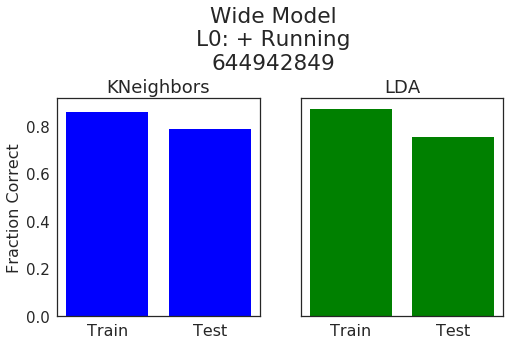

In [22]:
scores_k = model_selection.cross_validate(classifier_k,X,y)
# test = scores['test_score']
# test = test.tolist()
# train = scores['train_score']
# train = train.tolist()
# test.extend(train)

# test1 =['test', 'test', 'test', 'train','train', 'train']
# empty_df = pd.DataFrame()
# empty_df['category'] = test1
# empty_df['value'] = test
# empty_df
# sns.barplot(empty_df)
# #empty_df

fig, (ax1, ax2) = plt.subplots(1,2,figsize = (8, 4),sharey = True)
#ax1 = plt.subplot(111)
ax1.bar([0,1],[np.mean(scores_k['train_score']),np.mean(scores_k['test_score'])],color='b')
ax1.set_xticks([0,1])
ax1.set_xticklabels(['Train','Test'],fontsize=16)
ax1.set_ylabel('Fraction Correct',fontsize=16)
ax1.set_title('KNeighbors')
fig.suptitle('Wide Model\nL0: + Running\n'+str(experiment_list[0]), y = 1.2)
ax2.bar([0,1], [np.mean(scores['train_score']),np.mean(scores['test_score'])],color='g')
ax2.set_xticks([0,1])
ax2.set_xticklabels(['Train','Test'],fontsize=16)
ax2.set_ylabel('')
ax2.set_title('LDA')
#fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
